In [2]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader

from torchvision.datasets import *
from torchvision.transforms import *


no_cuda = False
use_gpu = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)
    
class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8),bias=False),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel,bias=False),
                nn.ReLU(inplace=True),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class ToyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.Conv = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1, stride=1,padding= 0, bias=True),
      h_swish(inplace=True),
      nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=3,padding= 1, bias=True,groups=8),
      h_swish(inplace=True),
      SELayer(8),
      nn.Conv2d(in_channels=8, out_channels=1, kernel_size=1, stride=1,padding= 0, bias=True),
      h_swish(inplace=True)
    )  
    self.backbone = nn.Sequential(
      nn.Linear(10*10, 120, bias=False),
      nn.ReLU(),
      nn.Linear(120, 84, bias=False),
      nn.ReLU(),
      nn.Linear(84, 10, bias=False)
    )

  def forward(self, x):
    x=self.Conv(x)
    x = x.view(-1, 10*10) #transform 28*28 figure to 784 vector
    x = self.backbone(x)
    return x


class Q_SELayer(nn.Module):
  def __init__(self,weights1,input_scale1,weight_scale1,output_scale1, input_zero_point1, weight_zero_point1, output_zero_point1,
               weights2, input_scale2, weight_scale2, output_scale2, input_zero_point2, weight_zero_point2, output_zero_point2,
               input_SE_scale,in_SE_zero_point,
               output_SE_scale,output_SE_zero_point,
               out_pool_scale,out_pool_zero_point):
    super().__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Sequential(
        QuantizedLinear(weights1,input_scale1,weight_scale1,output_scale1, input_zero_point1, weight_zero_point1, output_zero_point1),
        QuantizedLinear(weights2, input_scale2, weight_scale2, output_scale2, input_zero_point2, weight_zero_point2, output_zero_point2)
    )   
    self.input_SE_scale, self.in_SE_zero_point = input_SE_scale,in_SE_zero_point
    self.output_SE_scale, self.output_SE_zero_point = output_SE_scale, output_SE_zero_point,
    self.out_pool_scale, self.out_pool_zero_point = out_pool_scale,out_pool_zero_point
    self.linear_out_scale, self.linear_out_zero_point = output_scale2, output_zero_point2


  def forward(self,x):
    b, c, _, _ = x.size()
    y = self.avg_pool(x).view(b, c)
    y = (y- self.in_SE_zero_point) 
    y = do_fake_quant(y, self.input_SE_scale, self.out_pool_scale, self.out_pool_zero_point,bitwidth=8)
    y = self.fc(y).view(b, c, 1, 1)
    z = (x-self.in_SE_zero_point)*(y-self.linear_out_zero_point)
    return do_fake_quant(z, deq_scale=(self.input_SE_scale *self.linear_out_scale), 
                         q_scale=self.output_SE_scale, q_zero_point=self.output_SE_zero_point,bitwidth=8)
  
  def __repr__(self):
    return f"Quantized_SE(in_channels={self.fc[0].weights.size(1)}, out_channels={self.fc[1].weights.size(0)})"
    


class QuantizedConv(nn.Module):
  def __init__(self,bias ,weights,stride,padding,groups ,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point, bitwidth=8, activation_bitwidth=8):
    super().__init__()
    self.stride, self.padding, self.groups = stride, padding,groups
    self.weights = weights
    self.input_scale, self.input_zero_point = input_scale, input_zero_point
    self.weight_scale, self.weight_zero_point = weight_scale, weight_zero_point
    self.output_scale, self.output_zero_point = output_scale, output_zero_point
    self.bias = bias
    self.bitwidth = bitwidth
    self.activation_bitwidth = activation_bitwidth
    self.q_bias = torch.round(bias / (input_scale*weight_scale))
    self.q_weight = weights - weight_zero_point
    self.DeQ_scale = input_scale*weight_scale*8192
  def forward(self, x):
    return quantized_conv(x, self.bias, self.weights, self.stride, self.padding, self.groups, self.input_scale, self.weight_scale, self.output_scale, self.input_zero_point, self.weight_zero_point, self.output_zero_point, device)
  def __repr__(self):
    return f"QuantizedConv(in_channels={self.weights.size(1)}, out_channels={self.weights.size(0)})"

class QuantizedLinear(nn.Module):
  def __init__(self, weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point, bitwidth=8, activation_bitwidth=8):
    super().__init__()
    self.weights = weights
    self.input_scale, self.input_zero_point = input_scale, input_zero_point
    self.weight_scale, self.weight_zero_point = weight_scale, weight_zero_point
    self.output_scale, self.output_zero_point = output_scale, output_zero_point

    self.bitwidth = bitwidth
    self.activation_bitwidth = activation_bitwidth

  def forward(self, x):
    return quantized_linear(x, self.weights, self.input_scale, self.weight_scale, self.output_scale, self.input_zero_point, self.weight_zero_point, self.output_zero_point, device)
  def __repr__(self):
    return f"QuantizedLinear(in_channels={self.weights.size(1)}, out_channels={self.weights.size(0)})"

#Transform input data to correct integer range
class Preprocess(nn.Module):
  def __init__(self, input_scale, input_zero_point, activation_bitwidth=8):
    super().__init__()
    self.input_scale, self.input_zero_point = input_scale, input_zero_point
    self.activation_bitwidth = activation_bitwidth
  def forward(self, x):
    x = x / self.input_scale + self.input_zero_point
    x = x.round() 
    return x
  
class Quantizer(nn.Module):
  def __init__(self,scale,zero_point,bitwidth=8):
    super().__init__()
    self.scale = scale
    self.zero = zero_point
    self.store_scale = scale *64

  def forward(self,x):
    return do_requant(x,self.scale,self.zero)
    
    

def quantized_linear(input, weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point, device, bitwidth=8, activation_bitwidth=8):
  input, weights = input.to(device), weights.to(device)

  #####################################################

  M = input_scale * weight_scale / output_scale
  output = torch.nn.functional.linear((input - input_zero_point ), (weights - weight_zero_point))
  output *= M
  output += output_zero_point

  #####################################################

  #clamp and round
  output = output.round().clamp(-(2**(activation_bitwidth-1)), 2**(activation_bitwidth-1)-1)

  return output

def quantized_conv(input, bias,weights,stride, padding,groups,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point, device, bitwidth=8, activation_bitwidth=16):
  input, weights = input.to(device), weights.to(device)

  #####################################################

  M = input_scale * weight_scale 
  conv_bias = bias /M
  conv_bias = conv_bias.round()
  output_only_conv = torch.nn.functional.conv2d((input - input_zero_point ), (weights - weight_zero_point),bias = conv_bias ,stride=stride,padding=padding,groups=groups)
  output = M * output_only_conv
  #output += output_zero_point
  #####################################################

  #clamp and round
  output = output.clamp(-(2**(activation_bitwidth-1)), 2**(activation_bitwidth-1)-1)
  return output

def do_requant(input, scale,zero_point,bitwidth=8):
    output = input / scale
    output = output.round()
    output += zero_point
    output = output.round().clamp(-(2**(bitwidth-1)), 2**(bitwidth-1)-1)
    return output

def do_fake_quant(input, deq_scale, q_scale, q_zero_point,bitwidth=8):
    M = deq_scale/q_scale
    N = q_zero_point
    output = input * M
    output += N
    output = output.round().clamp(-(2**(bitwidth-1)), 2**(bitwidth-1)-1)
    return output

def signed_dec2hex_matrix_16b(input):
    '''Convert a matrix which data is signed decimal to 8 bits hex with 2's complement'''
    temp = []
    bin8 = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(16)] ) )
    for i in input:
        test =bin8(i)
        test = int(test,base=2)
        hex_test = hex(test)[2:].zfill(2)
        temp.append(hex_test)

    return temp

def signed_dec2hex_16b(input):
    '''Convert a number which data is signed decimal to 8 bits hex with 2's complement'''
    bin8 = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(16)] ) )
    test =bin8(input)
    test = int(test,base=2)
    hex_test = hex(test)[2:].zfill(2)

    return hex_test


def signed_dec2hex_matrix(input):
    '''Convert a matrix which data is signed decimal to 8 bits hex with 2's complement'''
    temp = []
    bin8 = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(8)] ) )
    for i in input:
        test =bin8(i)
        test = int(test,base=2)
        hex_test = hex(test)[2:].zfill(2)
        temp.append(hex_test)

    return temp

def signed_dec2hex(input):
    '''Convert a number which data is signed decimal to 8 bits hex with 2's complement'''
    bin8 = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(8)] ) )
    test =bin8(input)
    test = int(test,base=2)
    hex_test = hex(test)[2:].zfill(2)

    return hex_test


def golden_gen(golden_layer_decimal):
    '''Convert a layer output which is signed decimal in GPU to 8 bits hex with 2's complement in CPU and
     make it 4 element in a line, example of use : golden_gen(q_output_activation["Conv.3"]) '''
    golden = []
    i=0
    golden_in_numpy = golden_layer_decimal.cpu().numpy()
    test = golden_in_numpy.flatten()
    test =test.astype('int32')
    golden.append([])
    for j, data in enumerate(test):
        if(j%4==0 ):
            golden.append([])
            i = i+1
            golden[i].append(signed_dec2hex(data))
        if(j%4!=0):
            golden[i].append(signed_dec2hex(data))
    golden.pop(0)
    for indice,data in enumerate(golden):
        print(*data,sep='')

def input_or_weight_gen(layer_decimal):
    '''Convert a layer output which is signed decimal in GPU to 8 bits hex with 2's complement in CPU and
     make each byte display in different place, example of use : input_or_weight_gen(quantized_model.Conv[1].weights)'''
    byte0 = []
    byte1 = []
    byte2 = []
    byte3 = []

    data_in_numpy = layer_decimal.cpu().numpy()
    data_test = data_in_numpy.flatten()
    data_test = data_test.astype('int32')
    data_test = signed_dec2hex_matrix(data_test)
    for indice,data in enumerate(data_test):
        if(indice%4 == 0):
            byte0.append(data)
        elif(indice%4 == 1):
            byte1.append(data)
        elif(indice%4 == 2):
            byte2.append(data)
        else:
            byte3.append(data)
    print("byte0:",*byte0)
    print("=======")
    print("byte1:",*byte1)
    print("=======")
    print("byte2:",*byte2)
    print("=======")
    print("byte3:",*byte3)
    print("=======")
    return byte0,byte1,byte2,byte3


def bias_gen(layer_decimal):
    byte0 = []
    byte1 = []
    byte2 = []
    byte3 = []
    temp1 = []

    data_in_numpy = layer_decimal.cpu().numpy()
    data_test = data_in_numpy.flatten()
    data_test = data_test.astype('int32')
    data_test = signed_dec2hex_matrix_16b(data_test)
    for indice,data in enumerate(data_test):
        if(indice%2 == 0):
            if(len(data)==1):
                byte1.append('00')
                byte0.append('0'+str(data))
            elif(len(data)==2):
                byte1.append('00')
                byte0.append(data)
            elif(len(data)==3):
                temp = data[2]
                byte1.append('0'+data[0])
                byte0.append(data[1]+data[2])
            elif(len(data)==4):
                byte1.append(data[0:2])
                byte0.append(data[2:4])
        elif(indice%2 == 1):
            if(len(data)==1):
                byte3.append('00')
                byte2.append('0'+str(data))
            elif(len(data)==2):
                byte3.append('00')
                byte2.append(data)
            elif(len(data)==3):
                byte3.append('0'+data[0])
                byte2.append(data[1]+data[2])
            elif(len(data)==4):
                byte3.append(data[0:2])
                byte2.append(data[2:4])

    print("byte0:",*byte0)
    print("=======")
    print("byte1:",*byte1)
    print("=======")
    print("byte2:",*byte2)
    print("=======")
    print("byte3:",*byte3)
    print("=======")
    return byte0,byte1,byte2,byte3

def DecToBin_machine(num,accuracy):
    integer = int(num)
    flo = num - integer
    integercom = '{:1b}'.format(integer)
    tem = flo
    flo_list = []
    for i in range(accuracy):
        tem *= 2
        flo_list += str(int(tem))
        tem -= int(tem)
    flocom = flo_list
    binary_value =  ''.join(flocom)
    return binary_value


/home/kevin199907/.conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 32

#Dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

model = torch.load('dw_customize_Toymodel.pt',map_location=device)
print(model)

ToyModel(
  (Conv): Sequential(
    (0): Preprocess()
    (1): QuantizedConv(in_channels=1, out_channels=8)
    (2): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (3): Quantizer()
    (4): QuantizedConv(in_channels=1, out_channels=8)
    (5): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (6): Quantizer()
    (7): Quantized_SE(in_channels=8, out_channels=8)
    (8): QuantizedConv(in_channels=8, out_channels=1)
    (9): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (10): Quantizer()
  )
  (backbone): Sequential(
    (0): QuantizedLinear(in_channels=100, out_channels=120)
    (1): QuantizedLinear(in_channels=120, out_channels=84)
    (2): QuantizedLinear(in_channels=84, out_channels=10)
  )
)


In [5]:
# add hook to record the min max value of the activation
q_input_activation = {}
q_output_activation = {}

#Define a hook to record the feature map of each layer
def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        q_input_activation[module_name] = x.detach()
        q_output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (QuantizedConv,  QuantizedLinear,h_swish,Quantizer,Preprocess)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))


    return all_hooks


q_test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
hooks = add_range_recoder_hook(model)
sample_data = iter(q_test_loader).__next__()[0].to(device) #Use a batch of training data to calibrate
model(sample_data) #Forward to use hook
#print(quantized_model.Conv[1].weights)
print(q_output_activation.keys())
# print(q_input_activation["Conv.2"])
#print(q_output_activation["Conv.4"])
# print(quantized_model.Conv[1].bias)
# print(quantized_model.Conv[1].q_bias)
# print(quantized_model.Conv[1].input_scale)
# print(quantized_model.Conv[1].weight_scale)
# remove hooks
for h in hooks:
    h.remove()

dict_keys(['Conv.0', 'Conv.1', 'Conv.2', 'Conv.3', 'Conv.4', 'Conv.5', 'Conv.6', 'Conv.7.fc.0', 'Conv.7.fc.1', 'Conv.8', 'Conv.9', 'Conv.10', 'backbone.0', 'backbone.1', 'backbone.2'])


In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 1

#Dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

#Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


loss_fn = nn.CrossEntropyLoss() #define loss function

def test_loop(dataloader, model, loss_fn):
  #set model to evaluate mode
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  with torch.no_grad():
    for x, y in dataloader:
      if use_gpu:
        x, y = x.cuda(), y.cuda()
      pred = model(x)
      test_loss = loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item() #calculate accuracy
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

test_loop(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 84.8%, Avg loss: 0.000000 



In [14]:
print( model.Conv[4].input_scale *  model.Conv[4].weight_scale*16384 )
print(DecToBin_machine( model.Conv[4].input_scale *  model.Conv[4].weight_scale*16384,8 ))
print(1/ model.Conv[6].scale)

0.707694528976893
10110101
53.57103390375497


(800,)


(array([221.,  11., 154.,  88., 119.,  60.,  46.,  18.,   6.,   6.,   8.,
         25.,   1.,   2.,   1.,  34.]),
 array([-128.   , -112.125,  -96.25 ,  -80.375,  -64.5  ,  -48.625,
         -32.75 ,  -16.875,   -1.   ,   14.875,   30.75 ,   46.625,
          62.5  ,   78.375,   94.25 ,  110.125,  126.   ]),
 <BarContainer object of 16 artists>)

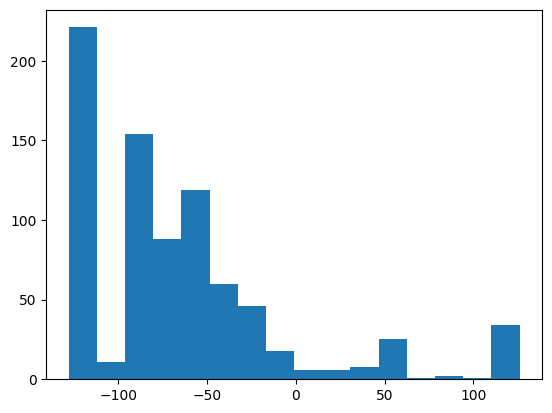

In [15]:
x = torch.flatten(q_output_activation['Conv.6'])
x = x.cpu()
x = torch.flatten(x)
x = x.detach()
x = x.numpy()
print(x.shape)

plt.hist(x, bins='auto',density=False)

In [5]:
#golden_gen(q_output_activation["Conv.3"])
#print(model.Conv[1].input_zero_point)
#input_or_weight_gen(q_input_activation["Conv.1"])
#print("===")

#input_or_weight_gen(model.Conv[1].weights)
print(model.Conv[4].q_bias)
bias_gen(model.Conv[4].q_bias)
print("=========dividen=============")
bias_gen(model.Conv[1].q_bias)
#golden_gen(q_output_activation["Conv.3"])
#print(model.Conv[1].DeQ_scale)
#print(model.Conv[3].scale)
print("deq_scale (shift 13):",DecToBin_machine(model.Conv[1].DeQ_scale*8192 ,8))
print("req_scale (shift 6):",DecToBin_machine(model.Conv[3].scale ,8))
#print("output zero",)


tensor([-22791., -22080.,  14448., -19011.,  -7044., -19033.,  11902., -20904.],
       device='cuda:0')
byte0: f9 70 7c 7e
byte1: a6 38 e4 2e
byte2: c0 bd a7 58
byte3: a9 b5 b5 ae
=========dividen=============
byte0: f9 70 7c 7e
byte1: a6 38 e4 2e
byte2: c0 bd a7 58
byte3: a9 b5 b5 ae
deq_scale (shift 13): 01011010
req_scale (shift 6): 00000001


In [6]:
golden_gen(q_output_activation["Conv.6"])

b2bababa
babababa
baafb9c4
c4c4c4c4
c4c4c4b6
b9c4c4c4
c4c4c5c4
c7b6b9c4
c4c4c5d3
e3d5e6b6
b9c4c4c5
caedfafd
fab8b9c5
c6d2ebf3
fbfbfac4
c6e8edf2
f4f8fafd
fdcbbdd9
e7e7e8de
d4eae9c1
b9c4c4c4
c4c4c4c4
c4b6b1b8
b8b8b8b8
b8b8b8af
b4bababa
babababa
baabb8c1
c1c1c1c1
c1c1c1ac
b8c1c1c1
c1c1c1c1
c1acb8c1
c1c1c1c0
bebfbdac
b8c1c1c1
c1bebcbb
bcacb8c1
c1c0bebd
bcbcbcab
b7bebebd
bdbcbcbb
bbabb8bf
bebdbdbf
c0bcbdac
b8c1c1c1
c1c1c1c1
c1acaeaf
afafafaf
afafafa4
f3383838
38383838
38ee397e
7e7e7e7e
7e7e7e2c
397e7e7e
7e7e7e7e
782c397e
7e7e7d5d
37522f2c
397e7e7d
7113eade
e720387e
7a601c03
e7e4e8eb
0c2c1909
04f2e6db
dbd6243e
1b1b132c
41f902f9
397e7e7e
7e7e7e7e
7e2c063b
3b3b3b3b
3b3b3bf8
a8a9a9a9
a9a9a9a9
a9a6abad
adadadad
adadada9
abadadad
adadaead
afa9abad
adadaeb8
c6bac8a9
abadadae
b0cfdadc
daaaabad
aeb7ced3
d9dbd9b1
b5c9ced2
d4d8dadc
dcb8afbd
cbcbcdc4
bacfcdb1
abadadad
adadadad
ada9a7a9
a9a9a9a9
a9a9a9a6
86868686
86868686
86868686
86868686
86868686
86868686
86868686
86868686
86868686
88888786
86868686
8